# Real-time epidemic modelling of SARS-CoV-2 from wastewater data

This is a sandbox for EDA and mathematical modelling of R estimate from viral RNA level in wastewater. Main equations referenced below.

## Data wrangling:
1. Change column names
2. Remove units in the data
3. Remove irregular values such as '(Empty)'
4. Subset to Jul 2020 to Mar 2021
5. Transform data to weekly

In [3]:
# Import libraries and set plot styles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
import statsmodels.graphics.gofplots as sm
from sklearn.linear_model import LinearRegression

# Show plots inline
%matplotlib inline

# Set plot style
# plot.style.available
plt.style.use('fivethirtyeight')

In [4]:
# Read in and preview data
df = pd.read_csv('/Users/FM/Public/HDS/Summer Project/local files/RNAMonitoring.txt', encoding = 'utf16', delimiter = "\t")
# df.head()

In [5]:
df

,SiteCode,Date,Population Band,Population,Result Description - N1 Gene,Reported Value - N1 Gene (gc/l),Days Since Sampled
0,ALLA,01/06/2020,10k - 100k,62058,Negative,0,703 days
1,ALLA,02/06/2020,10k - 100k,62058,Negative,0,702 days
2,ALLA,04/06/2020,10k - 100k,62058,Negative,0,700 days
3,ALLA,08/06/2020,10k - 100k,62058,Negative,0,696 days
4,ALLA,09/06/2020,10k - 100k,62058,Negative,0,695 days
...,...,...,...,...,...,...,...
10513,WINC,13/04/2022,2k - 4k,3860,Positive,142511,22 days
10514,WINC,20/04/2022,2k - 4k,3860,Positive,64315,15 days
10515,WINC,22/04/2022,2k - 4k,3860,Positive,374754,13 days
10516,WINC,26/04/2022,2k - 4k,3860,Positive,178649,9 days


In [6]:
# Show column names
# df.columns

# Check for duplicates (which there are none)
# df.drop_duplicates().describe(include='all')

# Rename columns
df.columns = ['sitecode', 'date', 'popband', 'pop', 'result_desc', 'gene', 'days_sampled']

# Inspect data types
# df.info()

# Check for missing values
# df.isna().sum()

# Overall statistics
# df.describe(include= 'all')

In [7]:
# Remove units in "number of days from sampling"
unit = ' days'
df['days_sampled'] = [sub.replace(unit, "").strip() for sub in df['days_sampled']]

In [8]:
# Count number of times population is "(Empty)"
# df.sitecode[df['pop']=='(Empty)'].value_counts()

In [9]:
# Convert datatypes and set factors
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Replace "(Empty)" with 1 for now (for population)
df = df.replace('(Empty)',1)

df = df.astype ({
    'popband':'category',
    "result_desc":"category",
    'pop':'int',
    'gene':'int',
    'days_sampled':'int'
})

In [10]:
# Overall statistics
# df.describe(include= 'all', datetime_is_numeric=True)

/var/folders/st/76qg2qy17gx68wvlkq_41fkw0000gn/T/ipykernel_51497/1455150655.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rnalevel['gene_pop'] = rnalevel['gene']/rnalevel['pop']*400 # 400L/person/day flow rate


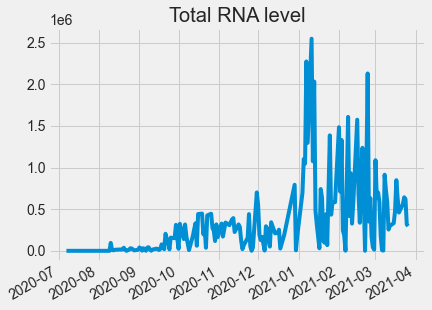

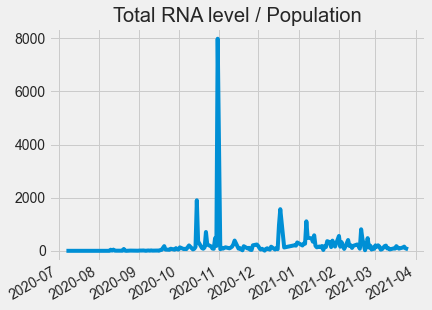

In [11]:
# Subsetting to Jul 2020 to Mar 2021
# Define first day as 6/7/2020 (Monday) (days_sampled=668) and last day as 28/3/2021 (days_sampled=403)

rows = (df['date'] > "2020-07-06") & (df['date'] <= "2021-03-28")
columns = ['sitecode', 'date', 'result_desc', 'gene', 'days_sampled']
rnalevel = df.loc[rows, :]

# RNA level per person
rnalevel['gene_pop'] = rnalevel['gene']/rnalevel['pop']*400 # 400L/person/day flow rate

# Raw gene level over time
gene_ts = rnalevel.groupby(['date']).agg({'gene': 'sum', 'pop':'sum'}).reset_index()
gene_ts['gene_pop'] = gene_ts['gene']/gene_ts['pop']*400 # 400L/person/day flow rate

ax = plt.subplot()
ax.plot(gene_ts['date'], gene_ts['gene'])
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.title('Total RNA level')
plt.show()

# By population
bx = plt.subplot()
bx.plot(gene_ts['date'], gene_ts['gene_pop'])
plt.setp(bx.get_xticklabels(), rotation=30, ha='right')
plt.title('Total RNA level / Population')
plt.show()

# Index by site and population band for later use
# siteinfo = rnalevel[['sitecode', 'popband', 'pop']].drop_duplicates()
# siteinfo.index.name='id'
# siteinfoid = siteinfo.reset_index()

In [12]:
# Inspect the spike in normalised RNA level
gene_ts[gene_ts['gene_pop']>6000]
rnalevel[rnalevel['date']=='2020-10-31']

,sitecode,date,popband,pop,result_desc,gene,days_sampled,gene_pop
3996,FORT,2020-10-31,4k - 10k,8222,Positive,164111,551,7983.994162


In [13]:
# Check table structure
# rnalevel.describe(include= 'all', datetime_is_numeric=True)

In [14]:
# Frequency of each site
rnalevel.sitecode.value_counts()

SHIE    126
ALLA    108
LEVE     92
CARB     80
NIGG     79
       ... 
BLAI      5
FORF      3
SELK      2
EYEM      2
KELS      2
Name: sitecode, Length: 92, dtype: int64

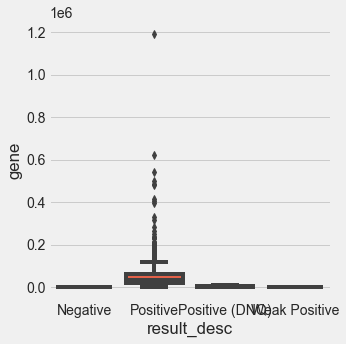

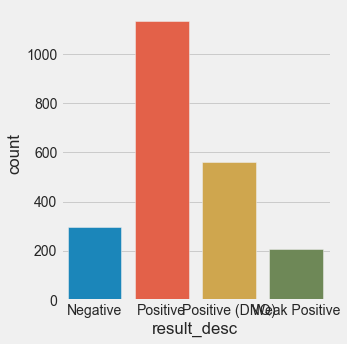

In [15]:
# Overall plots
sns.catplot(x='result_desc', y='gene', data=rnalevel, kind='box') # spread of RNA level in diff categories
sns.catplot(x='result_desc', data=rnalevel, kind='count') # frequency of different result categories

In [16]:
# Number of sites with more than one value of population
dfg = rnalevel.groupby(['sitecode']).filter(lambda x: x['pop'].nunique() > 1)
dfg['sitecode'].nunique()

3

In [17]:
# import more libraries for interactive plots (Plotly)
import cufflinks as cf
import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.graph_objs as go

## Link to Plotly account with API key
tls.set_credentials_file(username='fmft', api_key='wMAgrLv5apRGVTeBcKdo')

## Set plot privacy (private only available for pro accounts)
# tls.set_config_file(world_readable=True, sharing='public')

**Checking the distribution of gene levels**

Does not fit

KstestResult(statistic=0.6981552942279179, pvalue=0.0)

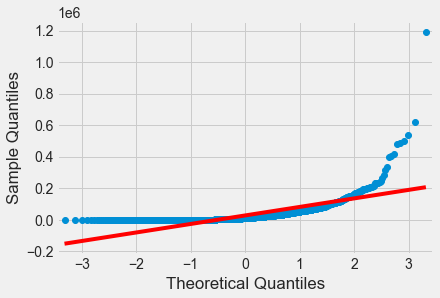

In [18]:
sample_size = 2194
stdnorm = np.random.normal(size=sample_size)
stdexp = np.random.exponential(size=sample_size)
stdpois = np.random.poisson(size=sample_size)

# Test for normal distribution
sm.ProbPlot(rnalevel['gene']).qqplot(line='s')

# Tets for poisson distribution
lambdapoisson = round(rnalevel['gene'].mean())
sc.kstest(rnalevel['gene'], 'poisson', args=(lambdapoisson,0))


## a) Transformation to Weekly Values
RNA levels are converted to weekly values

In [19]:
# Create new variable for week number
rnalevel['week'] = abs(rnalevel.loc[:,'days_sampled'] - 668) // 7 + 1

# Convert to weekly averages by site
# gene_weekly = rnalevel.groupby(['sitecode', 'week'])['gene'].mean()
gene_weekly = rnalevel.groupby(['sitecode', 'week']).agg({'gene': 'mean', 'pop':'mean'}).reset_index()

# Convert to overall weekly average
# gene_weekly_total = rnalevel.groupby(['week']).agg({'gene': 'mean', 'pop':'mean'}).reset_index()

# rename column
gene_weekly.rename(columns={'gene': 'mean_gene', 'pop': 'mean_pop'}, inplace=True)
# gene_weekly_total.rename(columns={'gene': 'mean_gene_total', 'pop': 'mean_pop_total'}, inplace=True)

# export cleaned dataset
gene_weekly.to_csv('data_cleaned.csv', index = False)
# gene_weekly_total.to_csv('total.csv', index = False)

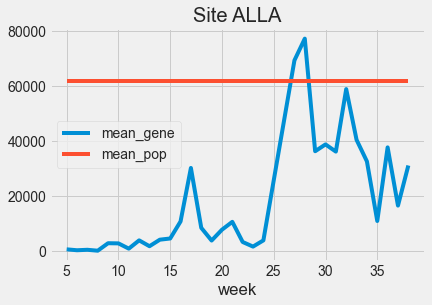

In [20]:
# Only look at RNA levels at site ALLA
ALLA = gene_weekly[gene_weekly['sitecode'].isin(['ALLA'])]
ALLA.set_index('week').plot(title="Site ALLA")

# Export only ALLA data for test
ALLA.to_csv("ALLA.csv", index = False)

# slice.unstack(level=0).plot(kind='line') #for multi-index object, unstack before plotting

In [27]:
# rnalevel[rnalevel['sitecode'].isin(['ALLA'])]

,sitecode,week,mean_gene,mean_pop
0,ALLA,5,658.000000,62058.0
1,ALLA,6,329.000000,62058.0
2,ALLA,7,493.500000,62058.0
3,ALLA,8,164.500000,62058.0
4,ALLA,9,2884.250000,62058.0
5,ALLA,10,2828.000000,62058.0
6,ALLA,11,915.000000,62058.0
7,ALLA,12,3922.250000,62058.0
8,ALLA,13,1794.500000,62058.0
9,ALLA,14,4172.666667,62058.0


In [22]:
# Check if population changed over time
ALLA['mean_pop'].unique()

# Check week number of the earliest record of ALLA within study period
ALLA['week'].min()

5

## b) Smooth to daily RNA level
"Some values were missing or below limit of detection, they were replaced by their mean values over week number and sites. Remaining missing values are then replaced by the median for each week and for all sites together first, and then by the median for each site and for all dates otherwise. Finally, a log10 transformation was applied to all the concentration variables and the target variables to reduce the heavy skewness of their distribution."

"For the N1 gene the LoD was 1.7 gc L-1 and the LoQ was 11.8 gc L-1."

In [96]:
rng = pd.date_range(start='2020-08-07',
                    end='2021-03-31')
daily = rnalevel.copy()
daily.index = daily['date']
del daily['date']

# Linear interpolation
# Compare with forward-filling pad()
# and backward filling bfill()
daily_interpol = daily.groupby(['sitecode']).resample('D').mean()
daily_interpol['gene']=daily_interpol['gene'].interpolate()
daily_interpol['pop']=daily_interpol['pop'].interpolate()

# Create rolling average?
further_smoothing = daily_interpol.assign(smooth_gene = daily_interpol['gene'].rolling(window=7).mean())
# first 6 rows return NaN
further_smoothing

pop          gene  days_sampled     gene_pop  week  \
sitecode date                                                                 
ALLA     2020-08-07  62058.0    658.000000         636.0     4.241194   5.0   
         2020-08-08  62058.0    438.666667           NaN          NaN   NaN   
         2020-08-09  62058.0    219.333333           NaN          NaN   NaN   
         2020-08-10  62058.0      0.000000         633.0     0.000000   6.0   
         2020-08-11  62058.0    164.500000           NaN          NaN   NaN   
...                      ...           ...           ...          ...   ...   
WINC     2021-03-21   3860.0  34068.600000           NaN          NaN   NaN   
         2021-03-22   3860.0  33644.800000           NaN          NaN   NaN   
         2021-03-23   3860.0  33221.000000         408.0  3442.590674  38.0   
         2021-03-24   3860.0  18355.000000           NaN          NaN   NaN   
         2021-03-25   3860.0   3489.000000         406.0   361.554404  38.0   

                      smooth_gene  
sitecode date                      
ALLA     2020-08-07           NaN  
         2020-08-08           NaN  
         2020-08-09           NaN  
         2020-08-10           NaN  
         2020-08-11           NaN  
...                           ...  
WINC     2021-03-21  30819.257143  
         2021-03-22  32305.742857  
         2021-03-23  33388.857143  
         2021-03-24  32005.428571  
         2021-03-25  27455.285714  

[9972 rows x 6 columns]

In [97]:
# Reset index of date and sitecode
daily_interpol = daily_interpol.reset_index()

In [98]:
# Select interpolated data for site ALLA only
export = daily_interpol[daily_interpol['sitecode'].isin(['ALLA'])]

# Select date range
# rows2 = (daily_interpol['date'] > "2020-07-06") & (daily_interpol['date'] <= "2021-03-28")

# Select first 90 days for simulation
export = export[:90]

# Columns to extract
columns2 = ['date', 'sitecode', 'pop', 'gene']
export = export.loc[rows2, columns2]

In [99]:
# Export to csv
export.to_csv("ALLA_day.csv", index = False)
len(export)

90

## Regression (prototype)
To only use xgboost from original model, which uses all variables

In [ ]:
# Import R values dataset


# Regression of variables on RNA level
X = rnalevel['pop'].values.reshape(-1,1)
y = rnalevel['gene'].values

lm = LinearRegression()
model = lm.fit(X,y)
print(f'alpha = {model.intercept_}') # alpha = intercept
print(f'betas = {model.coef_}') # beta coefficient
model.score(X,y)

## ~Box-Cox transformation of 1 + x~
~Might not be appropriate to substitute all zero values as 1~

In [ ]:
# # Box-Cox Transformation (log(x+1) as there are zero values)
# from scipy.special import boxcox1p
# gene_weekly['mean_gene_pop_boxcox'] = boxcox1p(gene_weekly['mean_gene_pop'], 0.25)
# gene_weekly['mean_gene_boxcox'] = boxcox1p(gene_weekly['mean_gene'], 0.25)

## Mathematical approaches to estimate prevalence (It)
1. Equation from original paper
2. COVID19WasteWater package (see R code)

Equation from original ResearchSquare paper: <br>

&emsp; $P = \frac{C \times Q_{p}}{S \times V} $

$P$: Prevalence, or the proportion of population infected <br>
$C$: Viral RNA concentration in wastewater (gc/ml) <br>
$Q_{p}$: Volume of wastewater produced per person per day (L/day) ($400 L/person/day$) <br>
$S$: Shedding rate per day ($1.9 \times 10^6$) <br>
$V$: Volume of stool produced per person per day (ml/day) ($128 g/day \times 1.06 ml/g$)

In [ ]:
# Infectious cases = (concentration * Qp) / (S * V) * population

interim = gene_ts.dropna() # remove empty rows
It = interim['gene'] * 400 / (1.9e6 * 135.68) * interim['pop']

# Repeat with ALLA only
ALLA['alla_i'] = ALLA['mean_gene'] * 400 / (1.9e6 * 135.68) * ALLA['mean_pop']

In [ ]:
It.max()
ALLA['alla_i'].max()

In [ ]:
# Plot number of cases
fig,ax = plt.subplots()
ax.plot(ALLA.week,
        ALLA.mean_gene,
        color='#619CFF',
        marker='o')
ax.set_xlabel("week")
ax.set_ylabel("RNA level", color = '#619CFF')
ax.set_title("Phenomenological model estimates for ALLA")

# twin object with different y-axis
ax2=ax.twinx()
ax2.plot(ALLA.week,
         ALLA.alla_i,
         color='#F8766D')
ax2.set_ylabel("Infectious cases", color='#F8766D')

plt.show()

# Export plot
fig.savefig('ALLA pheno estimates.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

Equation from Achaiah et al. 2020:

&emsp; $ I_{t} = \frac{(R_{0})t}{SI} $

$I_{t}$ : number of cases at the time <br>
$R_{0}$: reproduction number <br>
$t$ : prediction time <br>
$SI$ : serial interval <br>